# Bit depth

It's worth checking the bit-depth of your data. You want to know:

- How it's stored, e.g. as 32-bit floats or 16-bit integers, etc.
- The histogram of values, e.g. -128 to +127, or floats in the range 0–1, etc.

You might be able to save some memory by reducing the actual storage bit-depth, without losing any fidelity.

In [1]:
import segyio

with segyio.open('../data/Penobscot_0-1000ms.sgy') as s:
    seismic = segyio.cube(s)

(-32767.0, 32767.0)

In [4]:
seismic.dtype

dtype('float32')

In [8]:
seismic[100, 100, 100:120]

array([  414.,  -166.,  -707.,  -836.,  -719.,  -416.,   183.,   781.,
         729.,   -75.,  -708.,  -433.,   230.,   333.,  -278., -1024.,
       -1195.,  -464.,   782.,  1606.], dtype=float32)

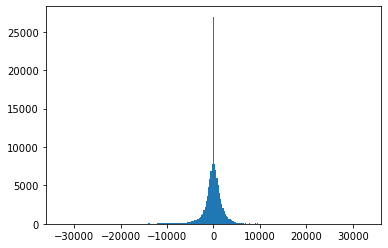

In [15]:
import matplotlib.pyplot as plt

_ = plt.hist(seismic[100].ravel(), bins=255)

This dataset is obstensibly "32-bit float" but these numbers are actually 16-bit integers:

In [23]:
seismic.min(), seismic.max()

(-32767.0, 32767.0)

In [24]:
2**16 // 2

32768

We can't recover the precision of floats, but these values are precise enough for any purpose.

This means we can reduce the bit-depth to 16-bits, and switch from floats to ints. We will not lose any precision.

## Convert to integers

Converting to integers will save 16 bits, or 2 bytes, per value. That's 50%, or...

In [73]:
f"{(seismic.nbytes // 2) // 1e6} MB of memory"

'145.0 MB of memory'

It's easy to do this in NumPy:

In [26]:
import numpy as np

s16int = seismic.astype(np.int16)

The result has the same histogram and the same values, but is represented as two-byte integers instead of 4-byte floats.

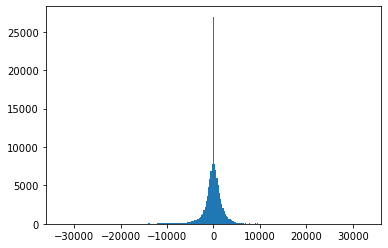

In [27]:
_ = plt.hist(s16int[100].ravel(), bins=255)

The size is now half the original volume.

In [28]:
s16int.nbytes // 1e6   # MB

145.0

In [3]:
!cp ../../geocomp-gg/master/Intro_to_interpolation.ipynb .

## Convert to 8-bit integers

Often, 8-bit ints are enough. We can convert to those, but we'll need to change the values.

### EXERCISE

Write a function, `bit_reduce()`, to change the data to 8-bit integers, losing as little dynamic range as possible.

You'll need to clip the data's tails, perhaps asking the user for a percentile to clip to. Then scale the data, put it in the range ±127, and cast to NumPy's `int8` dtype.

Call the new volume `seismic8`.

In [ ]:
# YOUR CODE HERE
# def bit_reduce(...):
#    ...
#    return

# Now call your function and make a plot.
seismic8 = bit_reduce(seismic, clip_perc=99.5)

plt.figure(figsize=(15, 3))
_ = plt.hist(seismic8[100].ravel(), bins=255)
plt.yscale('log')

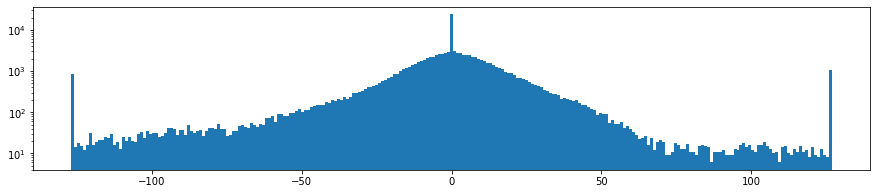

In [65]:
# YOUR CODE HERE
def bit_reduce(data, clip_perc=99):
    """
    Reduce bit-depth to 8-bit.
    """
    amax = np.percentile(abs(data), clip_perc)
    data = np.clip(data, -amax, amax)
    data = 127 * data / amax
    return data.astype(np.int8)

seismic8 = bit_reduce(seismic, clip_perc=99)

plt.figure(figsize=(15, 3))
_ = plt.hist(seismic8[100].ravel(), bins=255)
plt.yscale('log')

It might look severe, but remember that we're using a log scale on the y-axis here.

The data look fine:

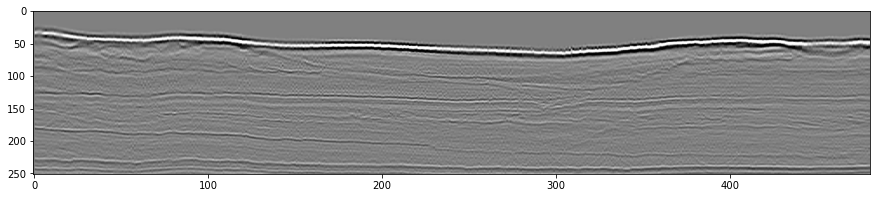

In [37]:
plt.figure(figsize=(15, 3))
plt.imshow(seismic8[100].T, aspect='auto', cmap='gray')

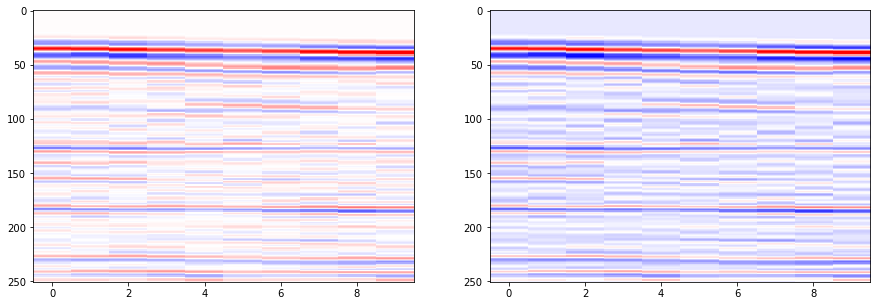

In [55]:
ma = np.percentile(np.abs(seismic), 99)

params = dict(aspect='auto', interpolation='none', cmap='bwr')

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 5))
ax0.imshow(seismic[100, 10:20].T, vmin=-ma, vmax=ma, **params)
ax1.imshow(seismic8[100, 10:20].T, **params)

## Visualize

Here's a trick to modify a matplotlib colormap so you can see clipped data at the ends:

In [71]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

rdbu = cm.get_cmap('RdBu', 256)

newcolors = rdbu(np.linspace(0, 1, 256))

yellow  = np.array([ 1, 1, 0, 1])
cyan = np.array([ 0, 1, 1, 1])

newcolors[:1, :] = yellow
newcolors[-1:, :] = cyan

newcmp = ListedColormap(newcolors)

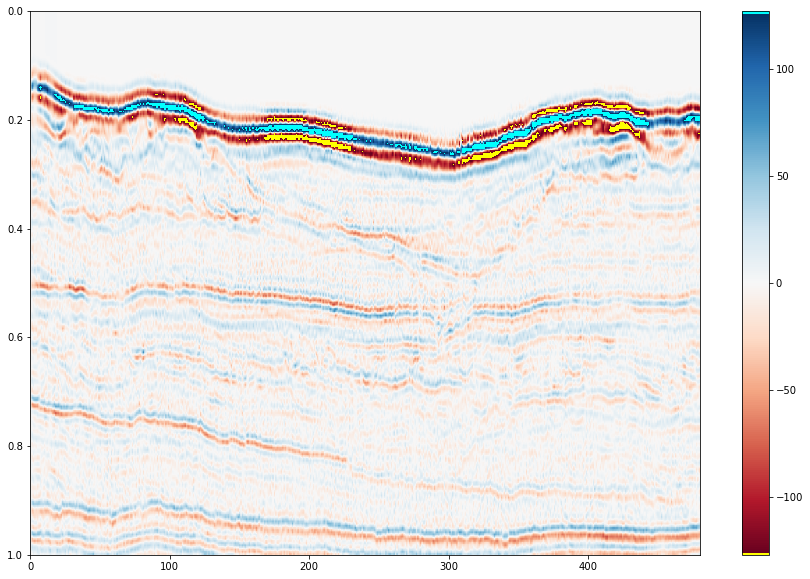

In [72]:
plt.figure(figsize=(15, 10))
plt.imshow(seismic8[100].T, aspect='auto', cmap=newcmp, extent=(0, 480, 1.0, 0), vmin=-127, vmax=127)
plt.colorbar()

---

© 2021 Agile Scientific